In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import random
from pprint import pprint

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
target_map = {i: name for i, name in enumerate(iris.target_names)}
df['target'] = df['target'].map(target_map)

In [31]:
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


---
## Train Test Split function

In [6]:
def train_test_split(df, test_size, seed=None):
    seed = random.seed(seed)
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    idxs = df.index.tolist()
    test_idxs = random.sample(population=idxs, k=test_size)
    test_df = df.loc[test_idxs]
    train_df = df.drop(test_idxs)

    return train_df, test_df

---
## Helper Functions

### Data Pure?

In [114]:
def check_purity(data):
    if isinstance(data, pd.DataFrame):
        data = data.values
    target_col = data[:,-1]
    unique_classes = np.unique(target_col)
    if len(unique_classes) == 1:
        return True
    else:
        return False

### Classify

In [112]:
def classify_data(data):
    if isinstance(data, pd.DataFrame):
        data = data.values
    target_col = data[:,-1]
    unique_classes, class_counts = np.unique(target_col, return_counts=True)
    index = class_counts.argmax()
    classification = unique_classes[index]
    return classification

### Potential Splits

In [121]:
def get_potential_splts(data):
    
    if isinstance(data, pd.DataFrame):
        data = data.values
        
    potential_splits = {}
    n_cols = data.shape[1]

    for col_idx in range(n_cols -1):
        potential_splits[col_idx] = []
        vals = data[:, col_idx]
        unique_vals = np.unique(vals)

        for i in range(1, len(unique_vals)):
                current_val = unique_vals[i]
                previous_val = unique_vals[i -1]
                potential_split = (current_val + previous_val) / 2
                potential_splits[col_idx].append(potential_split)

    return potential_splits

### Test potential splits function

In [46]:
potential_splits = get_potential_splts(df)

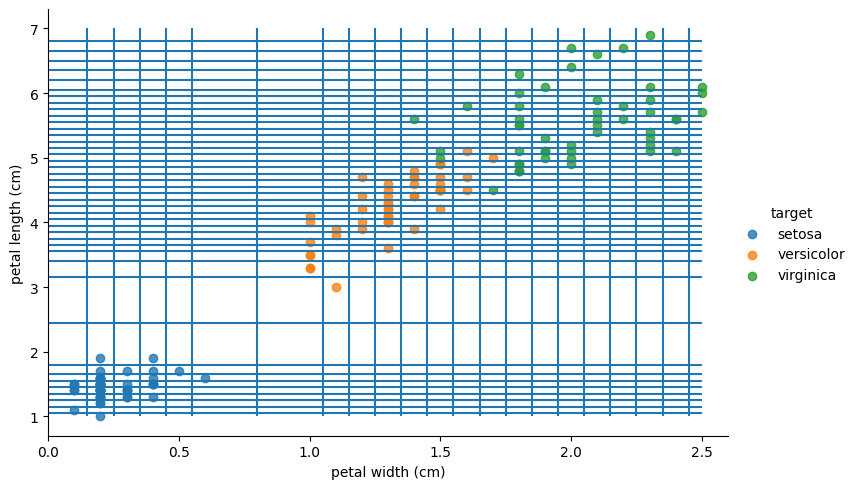

In [57]:
sns.lmplot(df, x='petal width (cm)', y='petal length (cm)', hue='target', fit_reg=False, aspect=1.5)

plt.vlines(x=potential_splits[3], ymin=1, ymax=7)
plt.hlines(y=potential_splits[2], xmin=0, xmax=2.5);

plt.xlim(0, max(df['petal width (cm)']) + 0.1)
#plt.ylim(1, max(df['petal length (cm)']) + 0.1)

plt.show()

### Split data

In [ ]:
def split_data(data, split_col, split_val):

    if isinstance(data, pd.DataFrame):
        data = data.values

    split_col = 3
    split_val = 0.8

    split_col_vals = data[:, split_col]

    data_below = data[split_col_vals <= split_val]
    data_above = data[split_col_vals > split_val]
    
    return data_below, data_above

In [61]:
split_col=3
split_val=0.8
data_below, data_above = split_data(df, split_col=split_col, split_val=split_val)

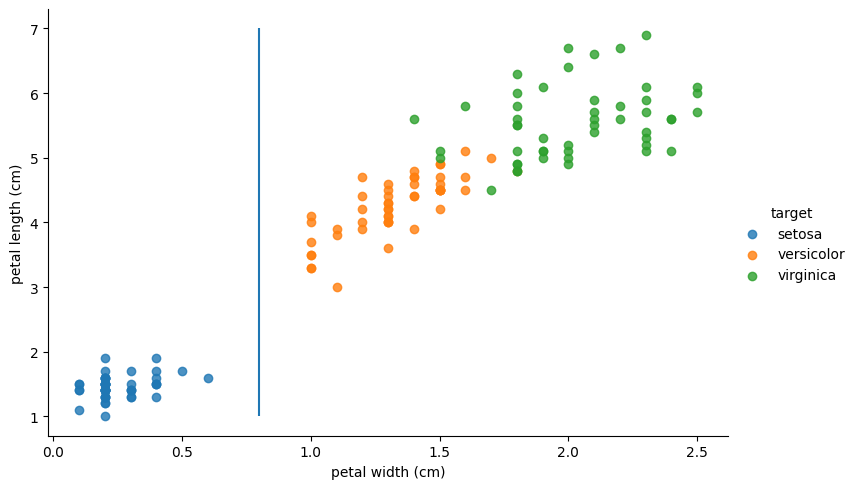

In [68]:
sns.lmplot(df, x='petal width (cm)', y='petal length (cm)', hue='target', fit_reg=False, aspect=1.5)
plt.vlines(x=split_val, ymin=1, ymax=7)
plt.show()

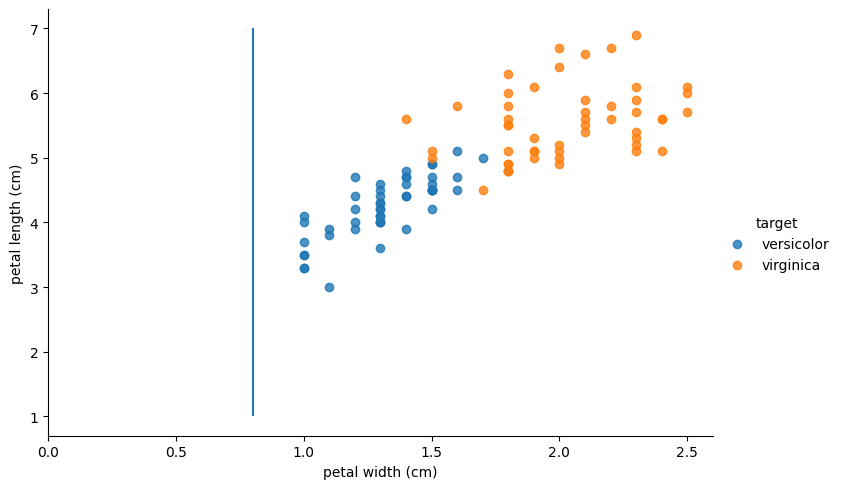

In [66]:
data_to_plot = pd.DataFrame(data_above, columns=df.columns)

sns.lmplot(data_to_plot, x='petal width (cm)', y='petal length (cm)', hue='target', fit_reg=False, aspect=1.5)
plt.vlines(x=split_val, ymin=1, ymax=7)

plt.xlim(0, 2.6)
plt.show()

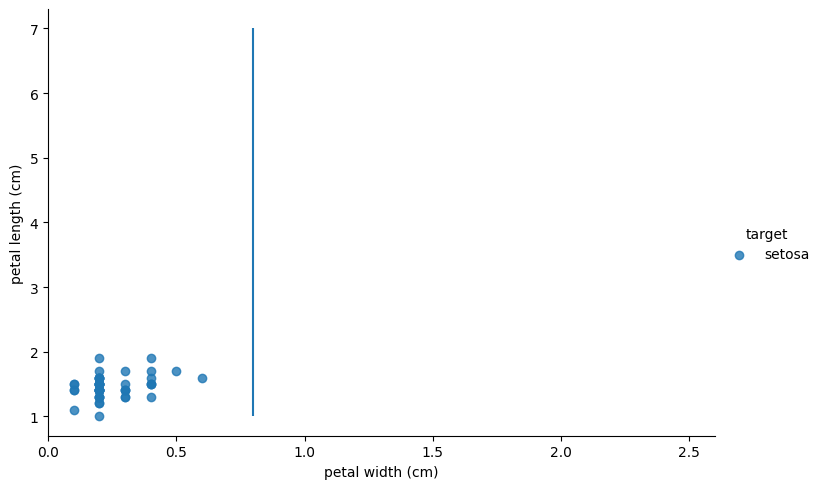

In [67]:
data_to_plot = pd.DataFrame(data_below, columns=df.columns)

sns.lmplot(data_to_plot, x='petal width (cm)', y='petal length (cm)', hue='target', fit_reg=False, aspect=1.5)
plt.vlines(x=split_val, ymin=1, ymax=7)

plt.xlim(0, 2.6)
plt.show()

### Lowest Overall Entropy

In [122]:
def calculate_entropy(data):

    if isinstance(data, pd.DataFrame):
        data = data.values

    target_col = data[:,-1]
    counts = np.unique(target_col, return_counts=True)[1]

    probabilities = counts/counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

In [123]:
calculate_entropy(df)

1.584962500721156

In [124]:
calculate_entropy(data_above)

1.0

In [125]:
calculate_entropy(data_below)

0.0

In [126]:
def calculate_overall_entropy(data_below, data_above):

    n_data = len(data_below) + len(data_above)
    
    p_data_below = len(data_below) / n_data
    p_data_above = len(data_above) / n_data

    overall_entropy = (p_data_below * calculate_entropy(data_below) +
                       p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [127]:
calculate_overall_entropy(data_below, data_above)

0.6666666666666666

In [128]:
def determine_best_split(data, potential_splits):

    if isinstance(data, pd.DataFrame):
        data = data.values

    overall_entropy = 99999

    for col_idx in potential_splits:
        for val in potential_splits[col_idx]:
            data_below, data_above = split_data(data, split_col=col_idx, split_val=val)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_col = col_idx
                best_split_val = val

    return best_split_col, best_split_val

In [129]:
potential_splits = get_potential_splts(df)

In [131]:
determine_best_split(df, potential_splits)

(3, 2.45)

---
## Decision Tree Algorithm

sub_tree = {question:[yes_answer, no_answer]}

In [133]:
def decision_tree_alg(df, counter=0):

    # Data preparation
    if counter == 0:
        data=df.values
    else:
        data = df

    # Base case
    if check_purity(data):
        classification = classify_data(data)
        return classification
    
    # Recursion
    else:
        counter += 1

        # Helper functions
        split_col, split_val = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_col, split_val)

        # Instatiate sub tree
        question = f'{split_col} <= {split_val}'
        subtree = {question: []}

        # Find answers using recursion
        yes_answer = decision_tree_alg(data_below, counter)
        no_answer = decision_tree_alg(data_above, counter)

        # Append question answers
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

        return subtree

In [134]:
tree = decision_tree_alg(df)

ZeroDivisionError: division by zero